In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import pyspark as spark
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
sc = spark.SparkContext()
sql = spark.SQLContext(sc)
from pyspark.sql.types import *
from sklearn.preprocessing import MinMaxScaler
import tensorflow
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from elephas.utils.rdd_utils import to_simple_rdd

In [2]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [3]:
df1 = pd.read_csv('btc_value_em_tweets_sentimental_score.csv')
df1.columns = ['DateTime','Compound','Positive', 'Neutral', 'Negative', 'Price']
df1 = df1[['DateTime','Negative','Neutral','Positive','Compound','Price']]
df1 = df1.sort_values('DateTime')
df1.head()

,DateTime,Negative,Neutral,Positive,Compound,Price
360,2020-07-01,0.0,0.0,0.0,0.0,9229.9
359,2020-07-02,0.0,0.0,0.0,0.0,9085.1
358,2020-07-03,0.0,0.0,0.0,0.0,9067.1
357,2020-07-04,0.0,0.0,0.0,0.0,9134.4
356,2020-07-05,0.0,0.0,0.0,0.0,9081.0


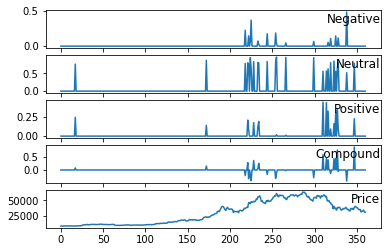

In [4]:
values = df1.values
# specify columns to plot
groups = [ 1,2,3,4,5]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(df1.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

In [5]:
df1.set_index('DateTime',inplace=True)  #making DateTime as index. Because we are doing Time series Analysis
cols = df1.columns.tolist()
cols = cols[-1:] + cols[:-1]   #just making the price as the first column
df1 = df1[cols]
df1.head()

,Price,Negative,Neutral,Positive,Compound
DateTime,,,,,
2020-07-01,9229.9,0.0,0.0,0.0,0.0
2020-07-02,9085.1,0.0,0.0,0.0,0.0
2020-07-03,9067.1,0.0,0.0,0.0,0.0
2020-07-04,9134.4,0.0,0.0,0.0,0.0
2020-07-05,9081.0,0.0,0.0,0.0,0.0


In [6]:
scaler = MinMaxScaler(feature_range=(0, 1)) #scaling values from 0 to 1
scaled = scaler.fit_transform(df1.values)

n_days = 1
n_features = 5              
n_obs = n_days*n_features

reframed = series_to_supervised(scaled, n_days, 1)  #t-3,t-2,t-1 values of all the columns. you can change n_hours for this
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
1,0.002989,0.0,0.0,0.0,0.326643,0.000330,0.0,0.0,0.0,0.326643
2,0.000330,0.0,0.0,0.0,0.326643,0.000000,0.0,0.0,0.0,0.326643
3,0.000000,0.0,0.0,0.0,0.326643,0.001235,0.0,0.0,0.0,0.326643
4,0.001235,0.0,0.0,0.0,0.326643,0.000255,0.0,0.0,0.0,0.326643
5,0.000255,0.0,0.0,0.0,0.326643,0.004991,0.0,0.0,0.0,0.326643


In [7]:
reframed = reframed.drop(reframed.columns[-4:], axis=1)  #dropping all the present values except present price
reframed.head()  #Note: here last column is present price which is our target variable

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t)
1,0.002989,0.0,0.0,0.0,0.326643,0.000330
2,0.000330,0.0,0.0,0.0,0.326643,0.000000
3,0.000000,0.0,0.0,0.0,0.326643,0.001235
4,0.001235,0.0,0.0,0.0,0.326643,0.000255
5,0.000255,0.0,0.0,0.0,0.326643,0.004991


In [8]:
cols = reframed.columns.tolist()
cols = cols[-1:] + cols[:-1]   #just making the price as the first column
reframed = reframed[cols]
reframed.head()

,var1(t),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1)
1,0.000330,0.002989,0.0,0.0,0.0,0.326643
2,0.000000,0.000330,0.0,0.0,0.0,0.326643
3,0.001235,0.000000,0.0,0.0,0.0,0.326643
4,0.000255,0.001235,0.0,0.0,0.0,0.326643
5,0.004991,0.000255,0.0,0.0,0.0,0.326643


In [9]:
from pyspark.ml.linalg import Vectors
reg_DF =sql.createDataFrame(reframed)
ad_df = reg_DF.rdd.map(lambda x: [Vectors.dense(x[1:]), x[0]]).toDF(['features', 'label'])
ad_df.show(5)

+--------------------+--------------------+
|            features|               label|
+--------------------+--------------------+
|[0.00298859268125...|3.304340802367245E-4|
|[3.30434080236724...|                 0.0|
|[0.0,0.0,0.0,0.0,...|0.001235456311107...|
|[0.00123545631110...|2.551685397383652E-4|
|[2.55168539738365...|0.004991390356464925|
+--------------------+--------------------+
only showing top 5 rows



In [10]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol = 'label')

In [11]:
lr_model = lr.fit(ad_df)

In [12]:
predictions = lr_model.transform(ad_df)
someDF = predictions.select("prediction", "label").show(5)

+--------------------+--------------------+
|          prediction|               label|
+--------------------+--------------------+
|0.006191256822918176|3.304340802367245E-4|
|0.003548733375988...|                 0.0|
|0.003220242892253777|0.001235456311107...|
|0.004448432311994012|2.551685397383652E-4|
|   0.003473910543582|0.004991390356464925|
+--------------------+--------------------+
only showing top 5 rows



In [13]:
predictions = predictions.toPandas().head()

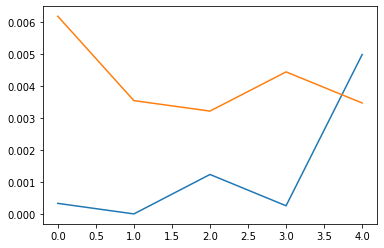

In [14]:
plt.plot(predictions['label'])
plt.plot(predictions['prediction'])
plt.show()

In [15]:
print("Coefficients: %s" % str(lr_model.coefficients))
print("Intercept: %s" % str(lr_model.intercept))

Coefficients: [0.9941180507139247,-0.01502405390288269,0.02893356351502765,-0.064249438856058,0.031560132313050604]
Intercept: -0.007088650295866829
